In [5]:
import json

# %matplotlib widget
# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# https://stackoverflow.com/a/37704379
def nested_get(dic, keys):    
    for key in keys:
        dic = dic[key]
    return dic


def read_data(fp):
    data = []
    with open(fp) as f:
        for line in f:
            data.append(json.loads(line))
    
    return data


# Returns just the object fields we care about
def wrangle(res):
    props = {
        "query":            "config.query",
        "faster_copy":      "extra.faster_copy",
        "num_events":       "perf.numEvents",
        "num_results":      "perf.numResults",
        "events_per_sec":   "perf.eventsPerSec",
        "results_per_sec":  "perf.resultsPerSec",
        "runtime_sec":      "perf.runtimeSec",
        "event_bytes_per_sec": "perf.eventBytesPerSec",
        "result_bytes_per_sec": "perf.resultBytesPerSec",
        "coder":            "config.coderStrategy",
        "avg_auction_size": "config.avgAuctionByteSize",
        "avg_bid_size":     "config.avgBidByteSize",
        "avg_person_size":  "config.avgPersonByteSize",
        "parallelism": "extra.parallelism",
    }
    ret = {name: nested_get(res["Result"], keys.split(".")) for name, keys in props.items()}
    return ret

# Battery 03

This battery of tests varies over: query, coder, faster copy. Each run is repeated 10 times.
The parallalism is 2

In [6]:
def bat3_convert_to_df(wr):
    df = pd.DataFrame.from_records(wr)
    df["coder"] = df["coder"].astype("category")
    df["query"] = df["query"].astype("category")

    # We do some preprocessing here.
    df = df.set_index(["query", "coder", "faster_copy"]).sort_index()

    return df

## Loading the data

We load the data from the dump from the go program

In [7]:
bat3_all = read_data("../results/new-res/bat03-01.json")
bat3_good = [wrangle(r) for r in bat3_all if r["Status"] == "OK"]
df =  bat3_convert_to_df(bat3_good)

## Question 1: How does `faster_copy` affect the different queries for normal queries

In [8]:
bf = df.xs(True, level=2) / df.xs(False, level=2)
bf = bf["events_per_sec"]

In [9]:
gg = bf.groupby(["query", "coder"]).agg(["mean", "std"])

In [10]:
((gg.xs("HAND", level=1) - 1)*100)["mean"]

query
AVERAGE_PRICE_FOR_CATEGORY          12.446056
AVERAGE_SELLING_PRICE_BY_SELLER     10.778654
CURRENCY_CONVERSION                233.729334
HOT_ITEMS                           32.997031
LOCAL_ITEM_SUGGESTION              214.923204
MONITOR_NEW_USERS                  119.674801
PASSTHROUGH                        172.579502
PROCESSING_TIME_WINDOWS             24.355242
SELECTION                          297.515213
SESSION_SIDE_INPUT_JOIN             12.771577
USER_SESSIONS                        6.639359
WINNING_BIDS                        11.431359
Name: mean, dtype: float64

In [11]:
jep = gg.unstack()["mean"].sort_values("HAND") - 1

In [12]:
jep

coder,AVRO,HAND,JAVA
query,,,
USER_SESSIONS,0.053207,0.066394,NaN
AVERAGE_SELLING_PRICE_BY_SELLER,0.126906,0.107787,NaN
WINNING_BIDS,0.119014,0.114314,NaN
AVERAGE_PRICE_FOR_CATEGORY,0.130876,0.124461,NaN
SESSION_SIDE_INPUT_JOIN,0.132861,0.127716,NaN
PROCESSING_TIME_WINDOWS,0.291851,0.243552,NaN
HOT_ITEMS,0.326386,0.329970,NaN
MONITOR_NEW_USERS,1.180014,1.196748,NaN
PASSTHROUGH,1.691676,1.725795,1.993973


<AxesSubplot:ylabel='query'>

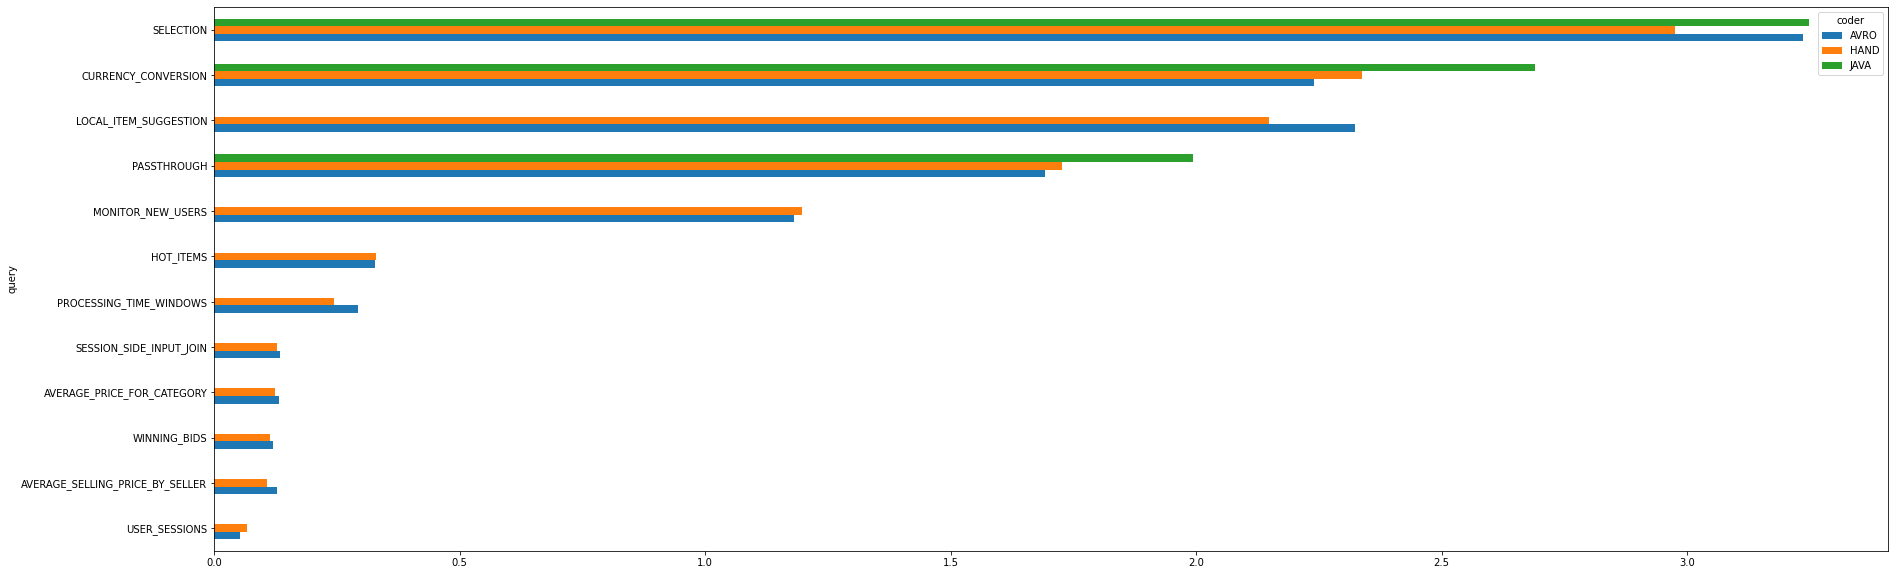

In [13]:
jep[(jep.isna() | (jep > 0)).all(axis=1)].plot(kind="barh", figsize=(30,10))

<AxesSubplot:ylabel='query'>

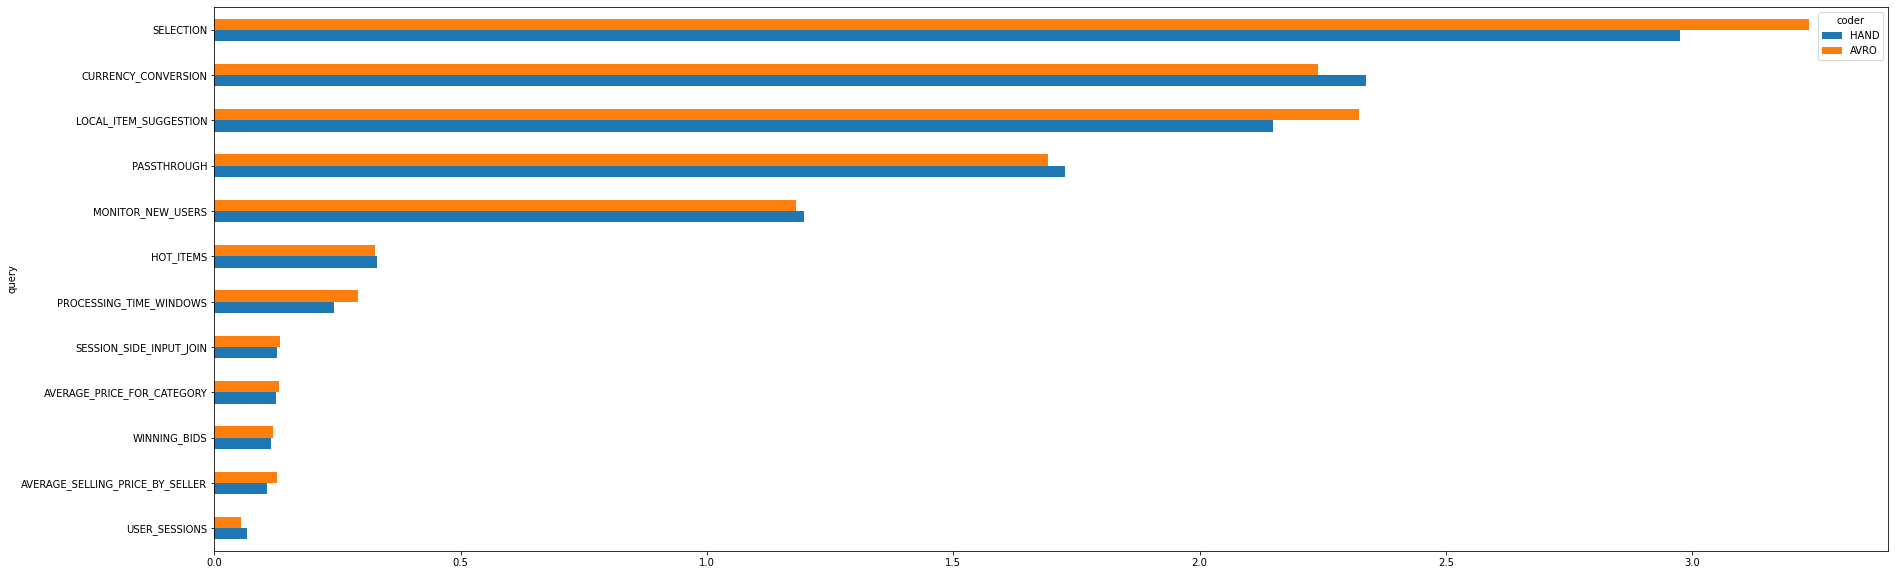

In [14]:
jep[["HAND", "AVRO"]].plot(kind="barh", figsize=(30,10))

Apparently the change is minimal between runners. The java serialiser only works
for certain queries. An outlier here is the `LOCAL_ITEM_SUGGESTION` query
where the `HAND` encoder perform a lot better.

One guess is that the queries which output a lot of records in the results would
be hit the hardest. We test this out.

In [15]:
results = df["num_results"].groupby("query").mean()

<AxesSubplot:ylabel='query'>

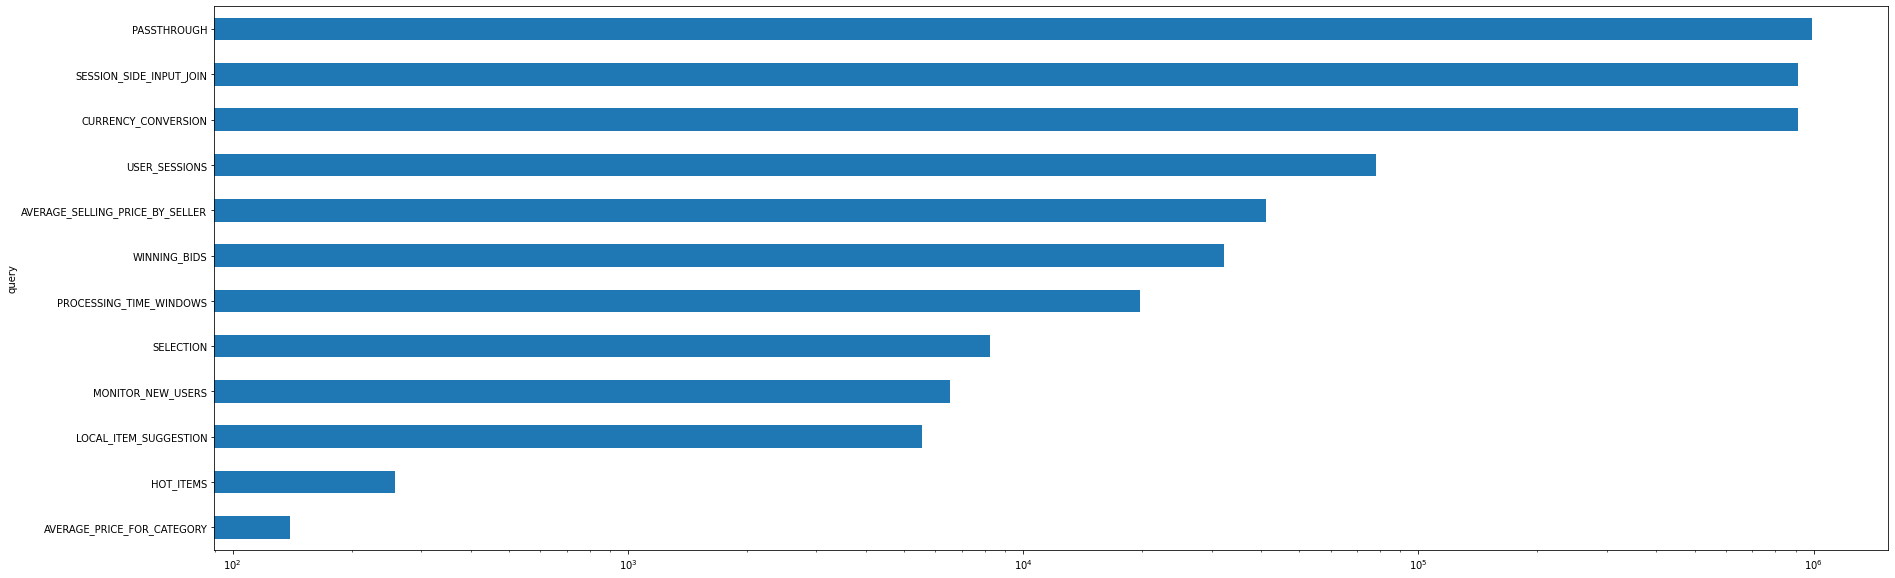

In [16]:
results.sort_values().plot(kind="barh", figsize=(30,10), logx=True)

Based on these results, this doesn't seem to be the case. It might be number of operators?

The `HIGHEST_BID` takes a lot of time to run and stalles, so it has been excluded from later benchmarks.

Since we have seen that the coders doesn't matter, let's look at just the hand coded results.

## Battery04: Does paralleism affect the speedup?

This battery tests if the number of parallel operators change how affected the benchmark is.
If there is no interplay here, there effect should simply be multiplied by the number of
paralllelism.

In [17]:
def bat4_convert_to_df(wr):
    df = pd.DataFrame.from_records(wr)
    df["coder"] = df["coder"].astype("category")
    df["query"] = df["query"].astype("category")

    # We do some preprocessing here.
    df = df.set_index(["query", "parallelism", "faster_copy", ]).sort_index()

    return df

In [18]:
bat4_all = read_data("../results/new-res/bat04-01.json")
bat4_good = [wrangle(r) for r in bat4_all if r["Status"] == "OK"]
df =  bat4_convert_to_df(bat4_good)

In [19]:
ef = df["events_per_sec"]

In [20]:
gf = ef.groupby(ef.index.names).agg("mean")

In [21]:
gf.unstack().unstack()

faster_copy                             False                               \
parallelism                                 1              2             4   
query                                                                        
AVERAGE_PRICE_FOR_CATEGORY       10518.084374    5418.620503   5328.330261   
AVERAGE_SELLING_PRICE_BY_SELLER  10556.568989    9580.462690   5204.816284   
CURRENCY_CONVERSION              37216.140207   42373.952684  27999.473908   
HOT_ITEMS                        29400.258101   13907.254566  14423.697988   
LOCAL_ITEM_SUGGESTION            60207.687546   34546.651939  33275.255664   
MONITOR_NEW_USERS                56567.357337  103517.095356  33608.174443   
PASSTHROUGH                      34169.903213   62284.515143  25833.510471   
PROCESSING_TIME_WINDOWS          55657.958752   24548.405916  24605.409307   
SELECTION                        65368.728006   50467.957058  48621.363984   
SESSION_SIDE_INPUT_JOIN          12309.495415    7134.293086   6837.849202   
USER_SESSIONS                    19645.967779   10140.844863   9576.881753   
WINNING_BIDS                     10539.574124    7475.405830   5316.521699   

faster_copy                              True                                 
parallelism                                  1              2              4  
query                                                                         
AVERAGE_PRICE_FOR_CATEGORY        11570.232625    7037.565054    6694.241551  
AVERAGE_SELLING_PRICE_BY_SELLER   11501.627957   19603.806125    6784.276427  
CURRENCY_CONVERSION              142407.566632  114216.940391  168086.115297  
HOT_ITEMS                         40227.171323   22656.255686   19677.136047  
LOCAL_ITEM_SUGGESTION            317017.291213  218693.478838  221169.422449  
MONITOR_NEW_USERS                250574.646007  373244.382090  126784.139755  
PASSTHROUGH                      103600.121773  184522.051640  106937.974486  
PROCESSING_TIME_WINDOWS           60212.649747   36957.765649   28302.130697  
SELECTION                        380159.981482  352027.896510  180466.805421  
SESSION_SIDE_INPUT_JOIN           13688.759439    9021.022617    8643.880383  
USER_SESSIONS                     20240.064368   12480.208360   12150.305378  
WINNING_BIDS                      11611.639568    7032.153380    6840.153204

In [22]:
# Find reduced events per second as the parallelism decreases
two_to_one = gf.xs(2, level=1) / gf.xs(1, level=1)
four_to_two = gf.xs(4, level=1) / gf.xs(2, level=1)
four_to_one = gf.xs(4, level=1) / gf.xs(1, level=1)
fff = pd.concat([two_to_one.rename("2/1"), four_to_two.rename("4/2"), four_to_one.rename("4/1")], axis=1).unstack()
fff - 1
#fff = fff.unstack().swaplevel(axis=1)
#fff.reindex(sorted(fff.columns), axis=1)

2/1                 4/2            \
faster_copy                         False     True      False     True    
query                                                                     
AVERAGE_PRICE_FOR_CATEGORY      -0.484828 -0.391753 -0.016663 -0.048784   
AVERAGE_SELLING_PRICE_BY_SELLER -0.092464  0.704438 -0.456726 -0.653931   
CURRENCY_CONVERSION              0.138591 -0.197957 -0.339229  0.471639   
HOT_ITEMS                       -0.526968 -0.436792  0.037135 -0.131492   
LOCAL_ITEM_SUGGESTION           -0.426209 -0.310153 -0.036802  0.011322   
MONITOR_NEW_USERS                0.829979  0.489554 -0.675337 -0.660319   
PASSTHROUGH                      0.822789  0.781099 -0.585234 -0.420460   
PROCESSING_TIME_WINDOWS         -0.558942 -0.386213  0.002322 -0.234203   
SELECTION                       -0.227950 -0.074001 -0.036589 -0.487351   
SESSION_SIDE_INPUT_JOIN         -0.420424 -0.340990 -0.041552 -0.041807   
USER_SESSIONS                   -0.483821 -0.383391 -0.055613 -0.026434   
WINNING_BIDS                    -0.290730 -0.394388 -0.288798 -0.027303   

                                      4/1            
faster_copy                         False     True   
query                                                
AVERAGE_PRICE_FOR_CATEGORY      -0.493412 -0.421426  
AVERAGE_SELLING_PRICE_BY_SELLER -0.506959 -0.410146  
CURRENCY_CONVERSION             -0.247652  0.180317  
HOT_ITEMS                       -0.509402 -0.510850  
LOCAL_ITEM_SUGGESTION           -0.447325 -0.302343  
MONITOR_NEW_USERS               -0.405873 -0.494026  
PASSTHROUGH                     -0.243969  0.032219  
PROCESSING_TIME_WINDOWS         -0.557918 -0.529964  
SELECTION                       -0.256198 -0.525287  
SESSION_SIDE_INPUT_JOIN         -0.444506 -0.368542  
USER_SESSIONS                   -0.512527 -0.399690  
WINNING_BIDS                    -0.495566 -0.410923

In [23]:
lf = gf.xs(True, level=2) / gf.xs(False, level=2)

In [24]:
jf = lf.unstack()

In [25]:
(jf - 1) * 100

parallelism,1,2,4
query,,,
AVERAGE_PRICE_FOR_CATEGORY,10.003231,29.877430,25.634884
AVERAGE_SELLING_PRICE_BY_SELLER,8.952331,104.622749,30.346127
CURRENCY_CONVERSION,282.650016,169.545164,500.318834
HOT_ITEMS,36.825912,62.909621,36.422269
LOCAL_ITEM_SUGGESTION,426.539557,533.038128,564.666335
MONITOR_NEW_USERS,342.966859,260.563036,277.241971
PASSTHROUGH,203.191148,196.256704,313.950611
PROCESSING_TIME_WINDOWS,8.183360,50.550573,15.024019
SELECTION,481.562458,597.527534,271.167714


In [26]:
gg = pd.concat([(jf[2] / jf[1]).rename("2/1"), (jf[4] / jf[2]).rename("4/2")], axis=1, names=["2/1", "4/2"])
gg

,2/1,4/2
query,,
AVERAGE_PRICE_FOR_CATEGORY,1.180669,0.967334
AVERAGE_SELLING_PRICE_BY_SELLER,1.878094,0.637007
CURRENCY_CONVERSION,0.704417,2.227155
HOT_ITEMS,1.190634,0.837411
LOCAL_ITEM_SUGGESTION,1.202261,1.049963
MONITOR_NEW_USERS,0.813973,1.046258
PASSTHROUGH,0.977128,1.397270
PROCESSING_TIME_WINDOWS,1.391624,0.764022
SELECTION,1.199403,0.532119


## Battery05: Does record size matter?

Change the size of the events to see if it has any effect. The idea is that
since the flink runner needs to marshal and unmarshal more.

The idea is to run adjust the bid size and use the currency converter as
it takes bids in and returns bids out.

In [27]:
def bat5_convert_to_df(wr):
    df = pd.DataFrame.from_records(wr)
    df["coder"] = df["coder"].astype("category")
    df["query"] = df["query"].astype("category")

    # We do some preprocessing here.
    df = df.set_index(["avg_bid_size", "faster_copy"]).sort_index()

    return df

In [37]:
bat5_all = read_data("../results/new-res/bat05-02.json")
bat5_good = [wrangle(r) for r in bat5_all if r["Status"] == "OK"]
df =  bat5_convert_to_df(bat5_good)

<AxesSubplot:xlabel='Avg Bid Size', ylabel='Events Per Second'>

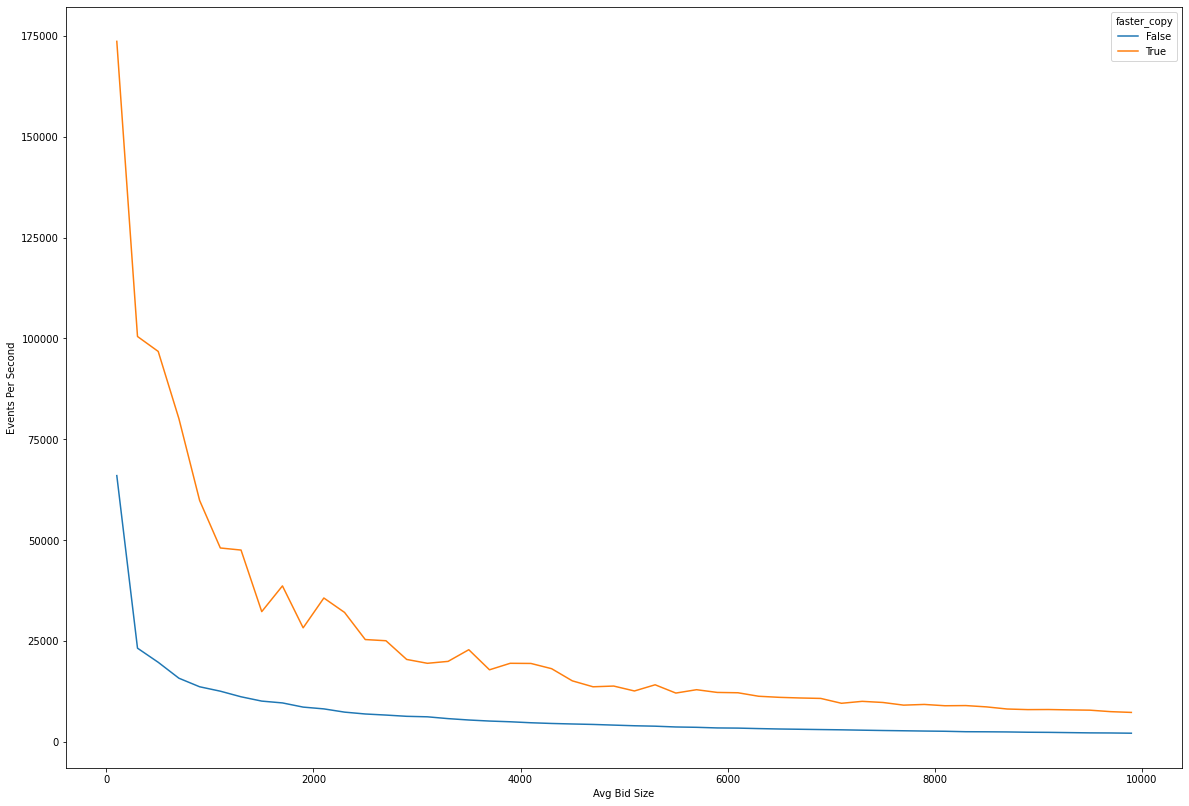

In [68]:
df.groupby(["avg_bid_size", "faster_copy"]).mean()["events_per_sec"].unstack().plot(figsize=(20,14), xlabel="Avg Bid Size", ylabel="Events Per Second")

In [29]:
kk = df["events_per_sec"].xs(True, level=1) / df["events_per_sec"].xs(False, level=1)

<AxesSubplot:xlabel='avg_bid_size'>

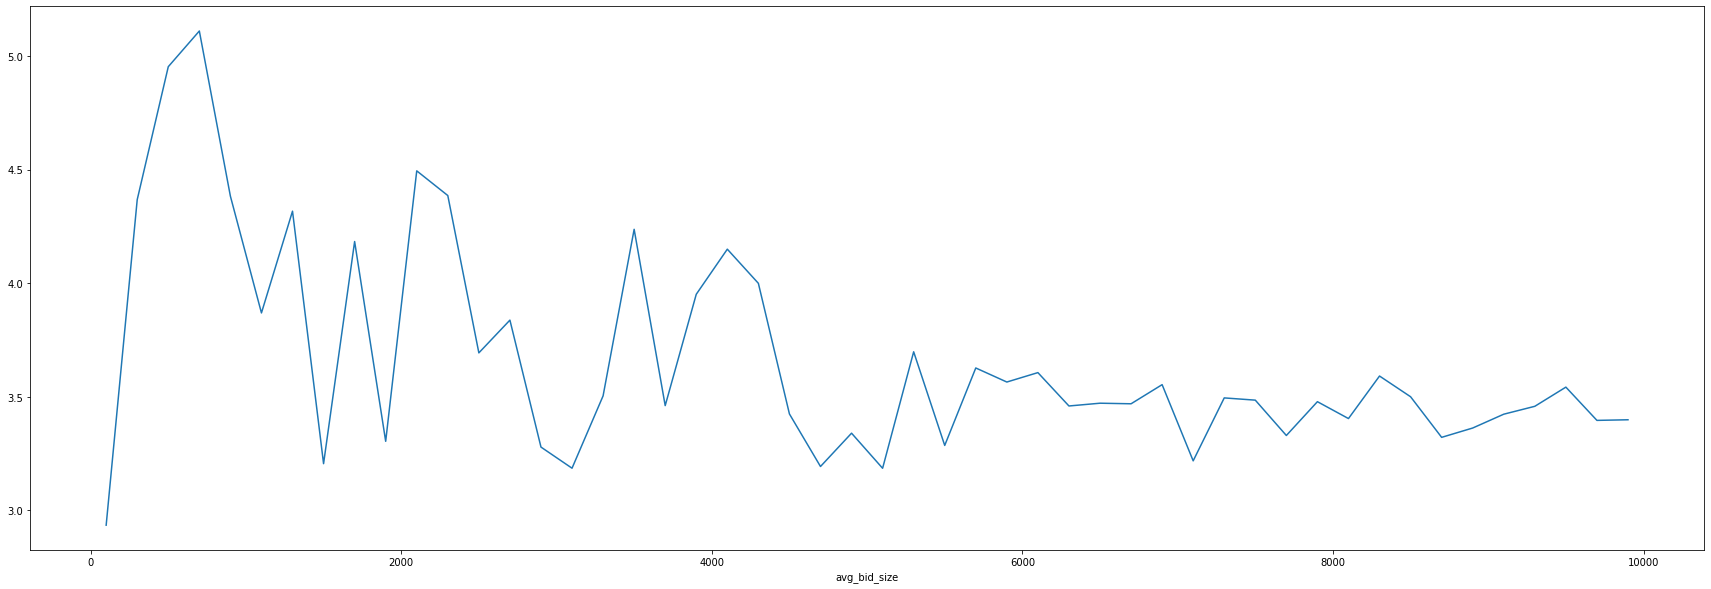

In [30]:
kk.groupby("avg_bid_size").mean().plot(figsize=(30,10))

Here it seems there is some increase, but it is minimal. The size has increased 10x fold, but the ratio has not
We are running the queries with more stances now.

Running with more seems to bear out the same conclusion, that it didn't really change much. This hints at the fact that the
bid size doesn't really have a say.

In [31]:
bb = df["event_bytes_per_sec"].xs(True, level=1) / df["event_bytes_per_sec"].xs(False, level=1)

<AxesSubplot:xlabel='avg_bid_size'>

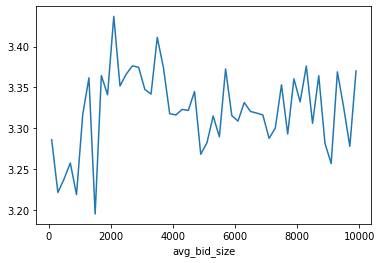

In [32]:
bb.groupby("avg_bid_size").median().plot()

In [33]:
df

query  num_events  num_results  \
avg_bid_size faster_copy                                                 
100          False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
             False        CURRENCY_CONVERSION     4958415      4561739   
...                                       ...         ...          ...   
9900         True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   
             True         CURRENCY_CONVERSION     4958415      4561739   

                          events_per_sec  results_per_sec  runtime_sec  \
avg_bid_size faster_copy                                                 
100          False         136731.055592    125792.493933       36.264   
             False         110772.865377    101910.973594       44.762   
             False         124661.596480    114688.598366       39.775   
             False         118268.694097    108807.131783       41.925   
             False          26531.052860     24408.553649      186.891   
...                                  ...              ...          ...   
9900         True            6992.241208      6432.857963      709.131   
             True            7203.334060      6627.063267      688.350   
             True            6727.105606      6188.933359      737.080   
             True            6616.592673      6087.261523      749.391   
             True            7015.470095      6454.228526      706.783   

                          event_bytes_per_sec  result_bytes_per_sec coder  \
avg_bid_size faster_copy                                                    
100          False               1.755097e+07          1.264188e+07  HAND   
             False               1.421895e+07          1.024184e+07  HAND   
             False               1.600172e+07          1.152596e+07  HAND   
             False               1.518112e+07          1.093489e+07  HAND   
             False               3.405560e+06          2.453008e+06  HAND   
...                                       ...                   ...   ...   
9900         True                6.393893e+07          6.368789e+07  HAND   
             True                6.586922e+07          6.561060e+07  HAND   
             True                6.151446e+07          6.127293e+07  HAND   
             True                6.050390e+07          6.026634e+07  HAND   
             True                6.415134e+07          6.389946e+07  HAND   

                          avg_auction_size  avg_person_size  parallelism  
avg_bid_size faster_copy                                                  
100          False                     500              200            4  
             False                     500              200            4  
             False                     500              200            4  
             False                     500              200            4  
             False                     500              200            4  
...                                    ...              ...          ...  
9900         True                      500              200            4  
             True                      500              200            4  
             True                      500              200            4  
             True                      500              200            4  
             True                      500              200            4  

[1000 rows x 12 columns]

<AxesSubplot:xlabel='avg_bid_size'>

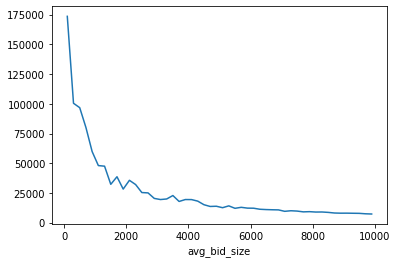

In [34]:
df.xs(True, level=1).groupby("avg_bid_size")["events_per_sec"].mean().plot()

<AxesSubplot:xlabel='avg_bid_size'>

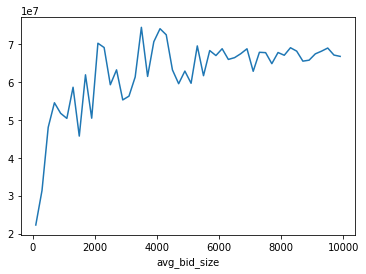

In [35]:
df.xs(True, level=1).groupby("avg_bid_size")["event_bytes_per_sec"].mean().plot()